<a href="https://colab.research.google.com/github/gabrielmprata/MVP_SP02_Linguagem_Natural/blob/main/MVP_SP02_Linguagem_Natural.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

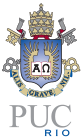 <font size="4"> **MVP de Machine Learning e Deep Learning**

---
>
**Pós-Graduação em Ciência de Dados e Analytics**
>
**Sprint 02**
>
**Aluno**: Gabriel Prata
>
**Data**: 05/06/2023
>
---

#**<font color=#FE8202> 1. Objetivo**

O objetivo desse estudo, é avaliar se a crítica foi positiva ou negativa, utilizando a  classificação de textos voltada à análise de sentimentos.

#**<font color=#FE8202> 2. Carga de Dados**

Com o intuido de ter mais sentenças de sentimentos, vamos importar três datasets, com avaliações de diferentes serviços e unifica-los em apenas um.
>
**Amazon**: Avaliações de produtos
>
**IMDB**: Avaliações de filmes
>
**YELP**: Avaliações de gastronomia


O dataset foi importado UC Irvine Machine Learning Repository
>
Para mais informações sobre o dataset, consulte:
>
https://archive.ics.uci.edu/dataset/331/sentiment+labelled+sentences

>**<font color=#FE8202> Dicionário de dados**

1.   **Review**    -  Avaliação escrita pelo usuário da plataforma.
2.   **sentiment** - Sentimento da avaliação, onde 0 é Ruim e 1 é Bom

>**<font color=#FE8202> Bibliotecas necessárias**

**<font color=RED> Importante!**

**Pode ser que nesse ponto, ocorra erro de execução, pois o arquivo Google News está em um servidor, e pode ser que esteja congestionado.**

In [1]:
#Tempo de execução 7 minutos

import gensim.downloader as api
#from gensim.matutils import softcossim
from gensim import corpora
# load pre-trained model
word2vec_model = api.load('word2vec-google-news-300')

In [2]:
#Setup
!pip install -U sentence-transformers

#from datetime import datetime, date, time
import time

# configuração para não exibir os warnings
import warnings
warnings.filterwarnings("ignore")

# Bibliotecas para manipulação de dados
import pandas as pd
import numpy as np
import string

# Visualização
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns


#Machine Learning
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, precision_score, recall_score, f1_score


# Processar os dados de entrada
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('rslp')
nltk.download('wordnet')
from nltk.tokenize import word_tokenize
from nltk.stem.porter import *
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.stem import WordNetLemmatizer
from scipy.spatial.distance import cosine
import networkx as nx
from wordcloud import WordCloud
from sentence_transformers import SentenceTransformer
import logging


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package rslp to /root/nltk_data...
[nltk_data]   Package rslp is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


>**<font color=#FE8202> Importando os arquivos**

In [3]:
# URL de importação
url  = "https://raw.githubusercontent.com/gabrielmprata/MVP_SP02_Linguagem_Natural/main/amazon_cells_labelled.txt"
url2 = "https://raw.githubusercontent.com/gabrielmprata/MVP_SP02_Linguagem_Natural/main/imdb_labelled.txt"
url3 = "https://raw.githubusercontent.com/gabrielmprata/MVP_SP02_Linguagem_Natural/main/yelp_labelled.txt"

amazon_df = pd.read_csv(url, delimiter='\t', header=None, names=['Review', 'sentiment'])

imdb_df = pd.read_csv(url2, delimiter='\t', header=None, names=['Review', 'sentiment'])

yelp_df = pd.read_csv(url3, delimiter='\t', header=None, names=['Review', 'sentiment'])

In [4]:
# Concatenação dos dados
# Utilizaremos o método "concat"

df_sentimentos = pd.concat([amazon_df, imdb_df, yelp_df], ignore_index=True)

#**<font color=#FE8202> 3. Análise de Dados Inicial**

###**<font color=#FE8202> 3.1. Quantitativas**

In [5]:
#	Quantidade de atributos e instâncias (linhas/colunas)
df_sentimentos.shape

(2748, 2)

In [6]:
# verificando os tipos de dados de cada coluna do dataframe
df_sentimentos.dtypes

Review       object
sentiment     int64
dtype: object

In [7]:
# Mostra diversas informações do Dataframe em um único comando
df_sentimentos.info(memory_usage="deep")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2748 entries, 0 to 2747
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Review     2748 non-null   object
 1   sentiment  2748 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 366.9 KB


In [8]:
# Exibe as 5 primeiras linhas (Default do comando head)
df_sentimentos.head()

Review  sentiment
0  So there is no way for me to plug it in here i...          0
1                        Good case, Excellent value.          1
2                             Great for the jawbone.          1
3  Tied to charger for conversations lasting more...          0
4                                  The mic is great.          1

In [9]:
# Exibe as 5 últimas linhas (Default do comando tail)
df_sentimentos.tail()

Review  sentiment
2743  I think food should have flavor and texture an...          0
2744                           Appetite instantly gone.          0
2745  Overall I was not impressed and would not go b...          0
2746  The whole experience was underwhelming, and I ...          0
2747  Then, as if I hadn't wasted enough of my life ...          0

In [10]:
# Quantidade de nulls no dataframe
df_sentimentos.isnull().sum()

Review       0
sentiment    0
dtype: int64

###**<font color=#FE8202> 3.2. Distribuição das classes**

In [11]:
# Verificar distribuição da classe
gr_class_balance =  df_sentimentos.groupby(["sentiment"]).count().reset_index()

In [12]:
fig0 = px.bar(gr_class_balance, x="sentiment", y="Review",
             template="plotly_dark",
             text_auto=True,
             height=500, #altura
             width=500,  #largura
             color_discrete_sequence=["#FE8202"],
             hover_data=['Review'],

             title = "Distribuição da classe")
fig0.update_traces(textposition='outside')
fig0.update_yaxes(showticklabels=True)
fig0.update_xaxes(showgrid=False)
fig0.update_yaxes(showgrid=True)
fig0.update_layout(xaxis = dict(linecolor='rgba(0,0,0,1)', # adicionando linha em y = 0
                                tickmode = 'array', # alterando o modo dos ticks
                                tickvals = gr_class_balance['sentiment'], # setando a posição do tick de x
                                ticktext = gr_class_balance['sentiment']),# setando o valor do tick de x
                                title_x = 0.5) #centralizando o titulo

fig0.show()

###**<font color=#FE8202> 3.3. Nuvem de palavras**

Vamos criar uma nuvem de palavras, que é a frequência ou a importância de cada palavra.
>
Isso é chamado de Tag Cloud ou WordCloud
>
Iremos fazer separado por meio de avaliação.

>**<font color=#FE8202> Avaliações da Amazon**

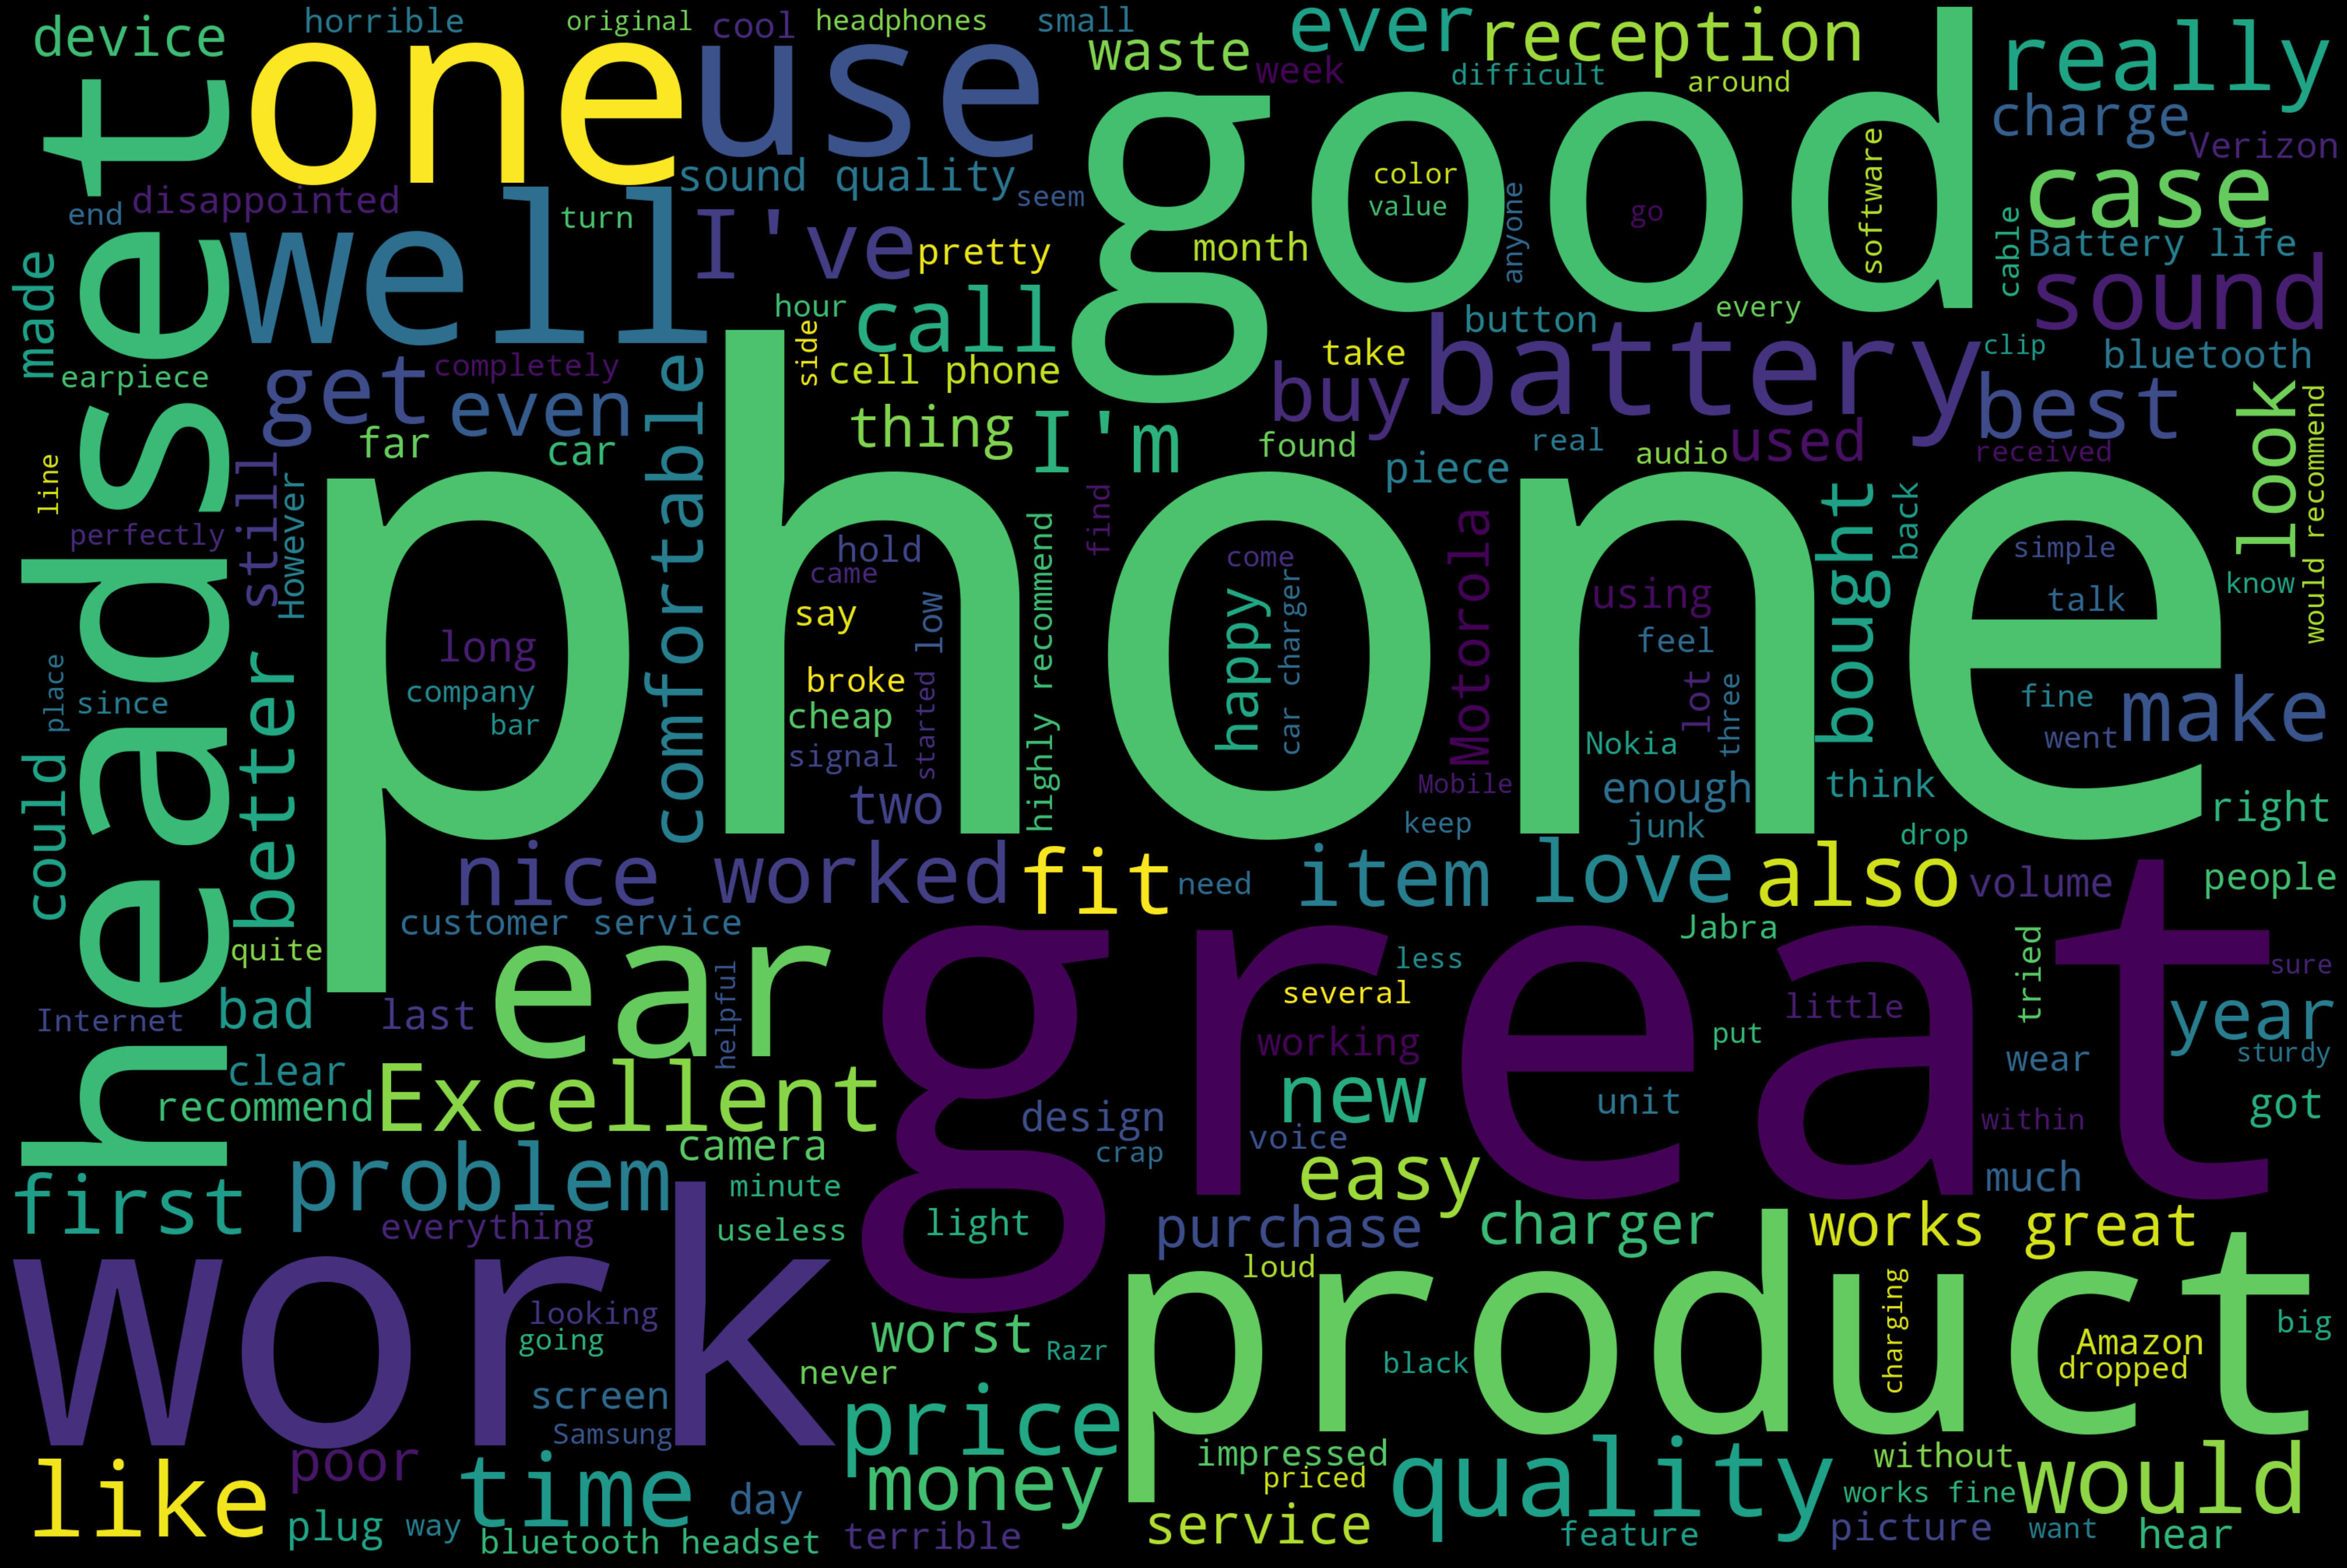

In [13]:
#WordCloud
# Coletar todas as palavras do dataset
text = ''
for review in amazon_df.Review.values:
    text += f" {review}"

#Construir a WordCloud
wordcloud = WordCloud(
    width = 3000,
    height = 2000,
    background_color = 'black',
    stopwords = set(nltk.corpus.stopwords.words("english"))).generate(text)

#Plotando
fig = plt.figure(
    figsize = (40, 30),
    facecolor = 'k',
    edgecolor = 'k')
plt.imshow(wordcloud, interpolation = 'bilinear') #Interpola melhor a visualização
plt.axis('off') #Retirando o eixo x e y
plt.tight_layout(pad=0)
plt.show()
del text

>**<font color=#FE8202> Avaliações do IMDB**

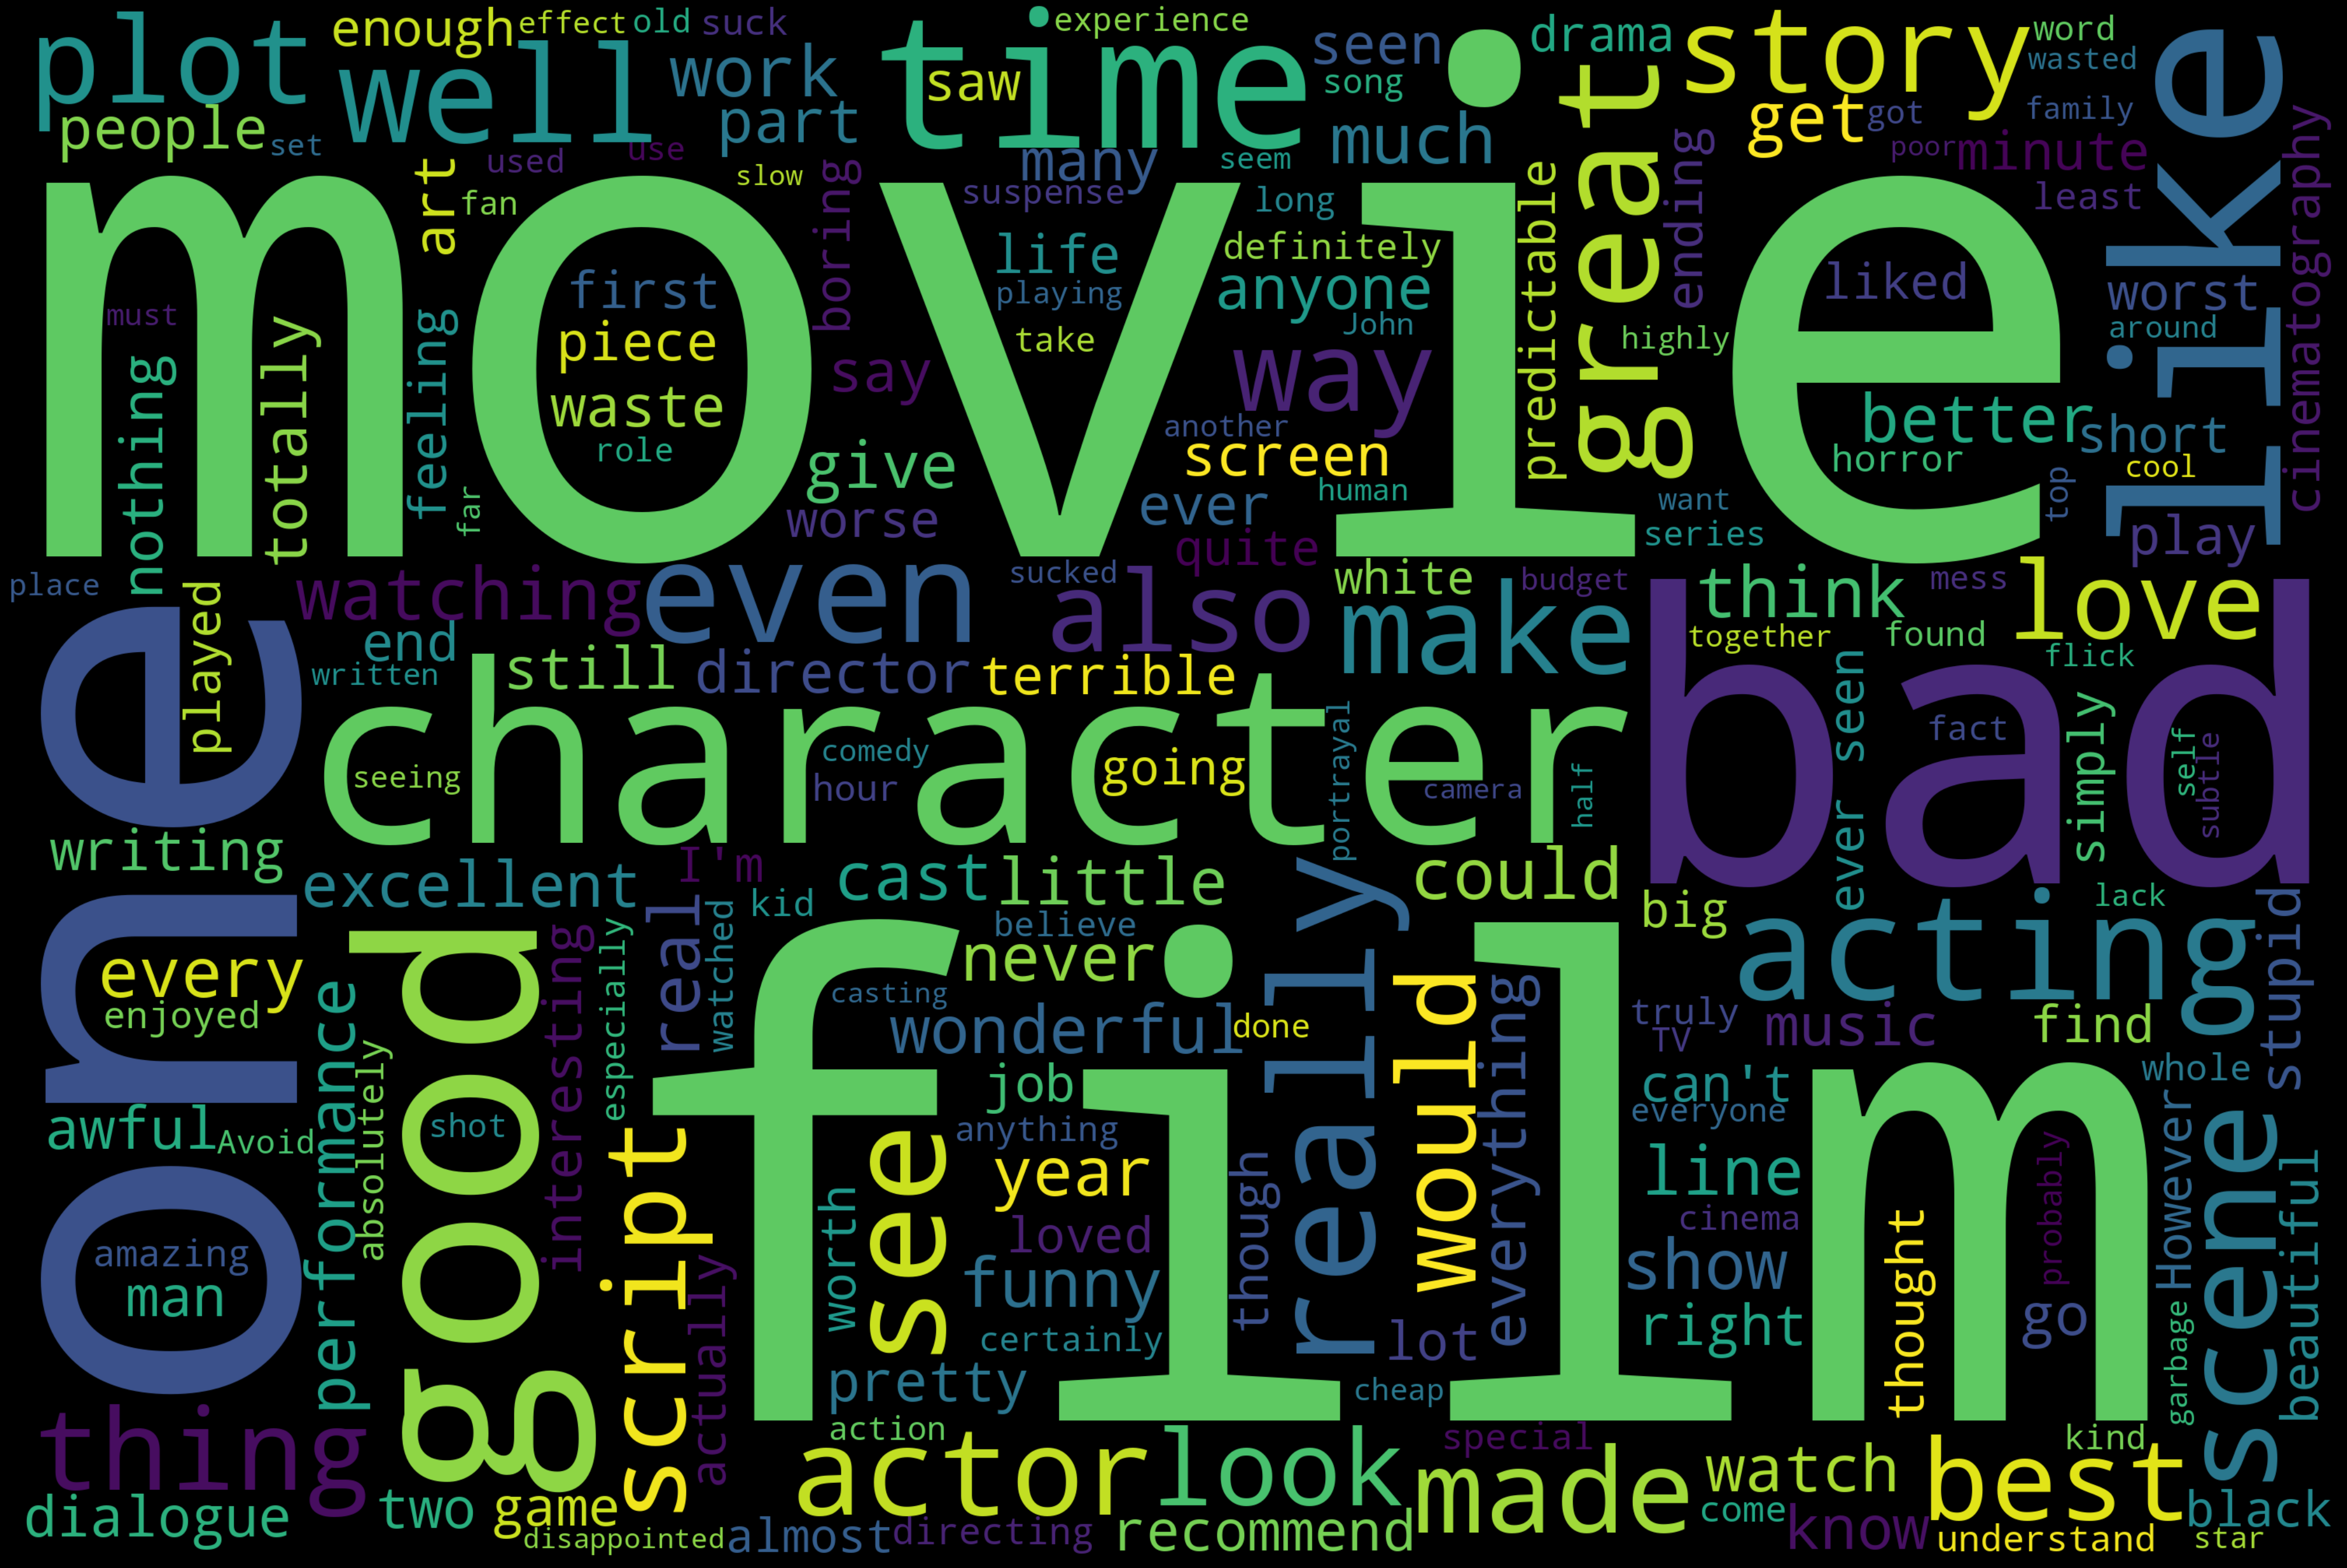

In [14]:
#WordCloud
# Coletar todas as palavras do dataset
text = ''
for review in imdb_df.Review.values:
    text += f" {review}"

#Construir a WordCloud
wordcloud = WordCloud(
    width = 3000,
    height = 2000,
    background_color = 'black',
    stopwords = set(nltk.corpus.stopwords.words("english"))).generate(text)

#Plotando
fig = plt.figure(
    figsize = (40, 30),
    facecolor = 'k',
    edgecolor = 'k')
plt.imshow(wordcloud, interpolation = 'bilinear') #Interpola melhor a visualização
plt.axis('off') #Retirando o eixo x e y
plt.tight_layout(pad=0)
plt.show()
del text

>**<font color=#FE8202> Avaliações da Yelp**

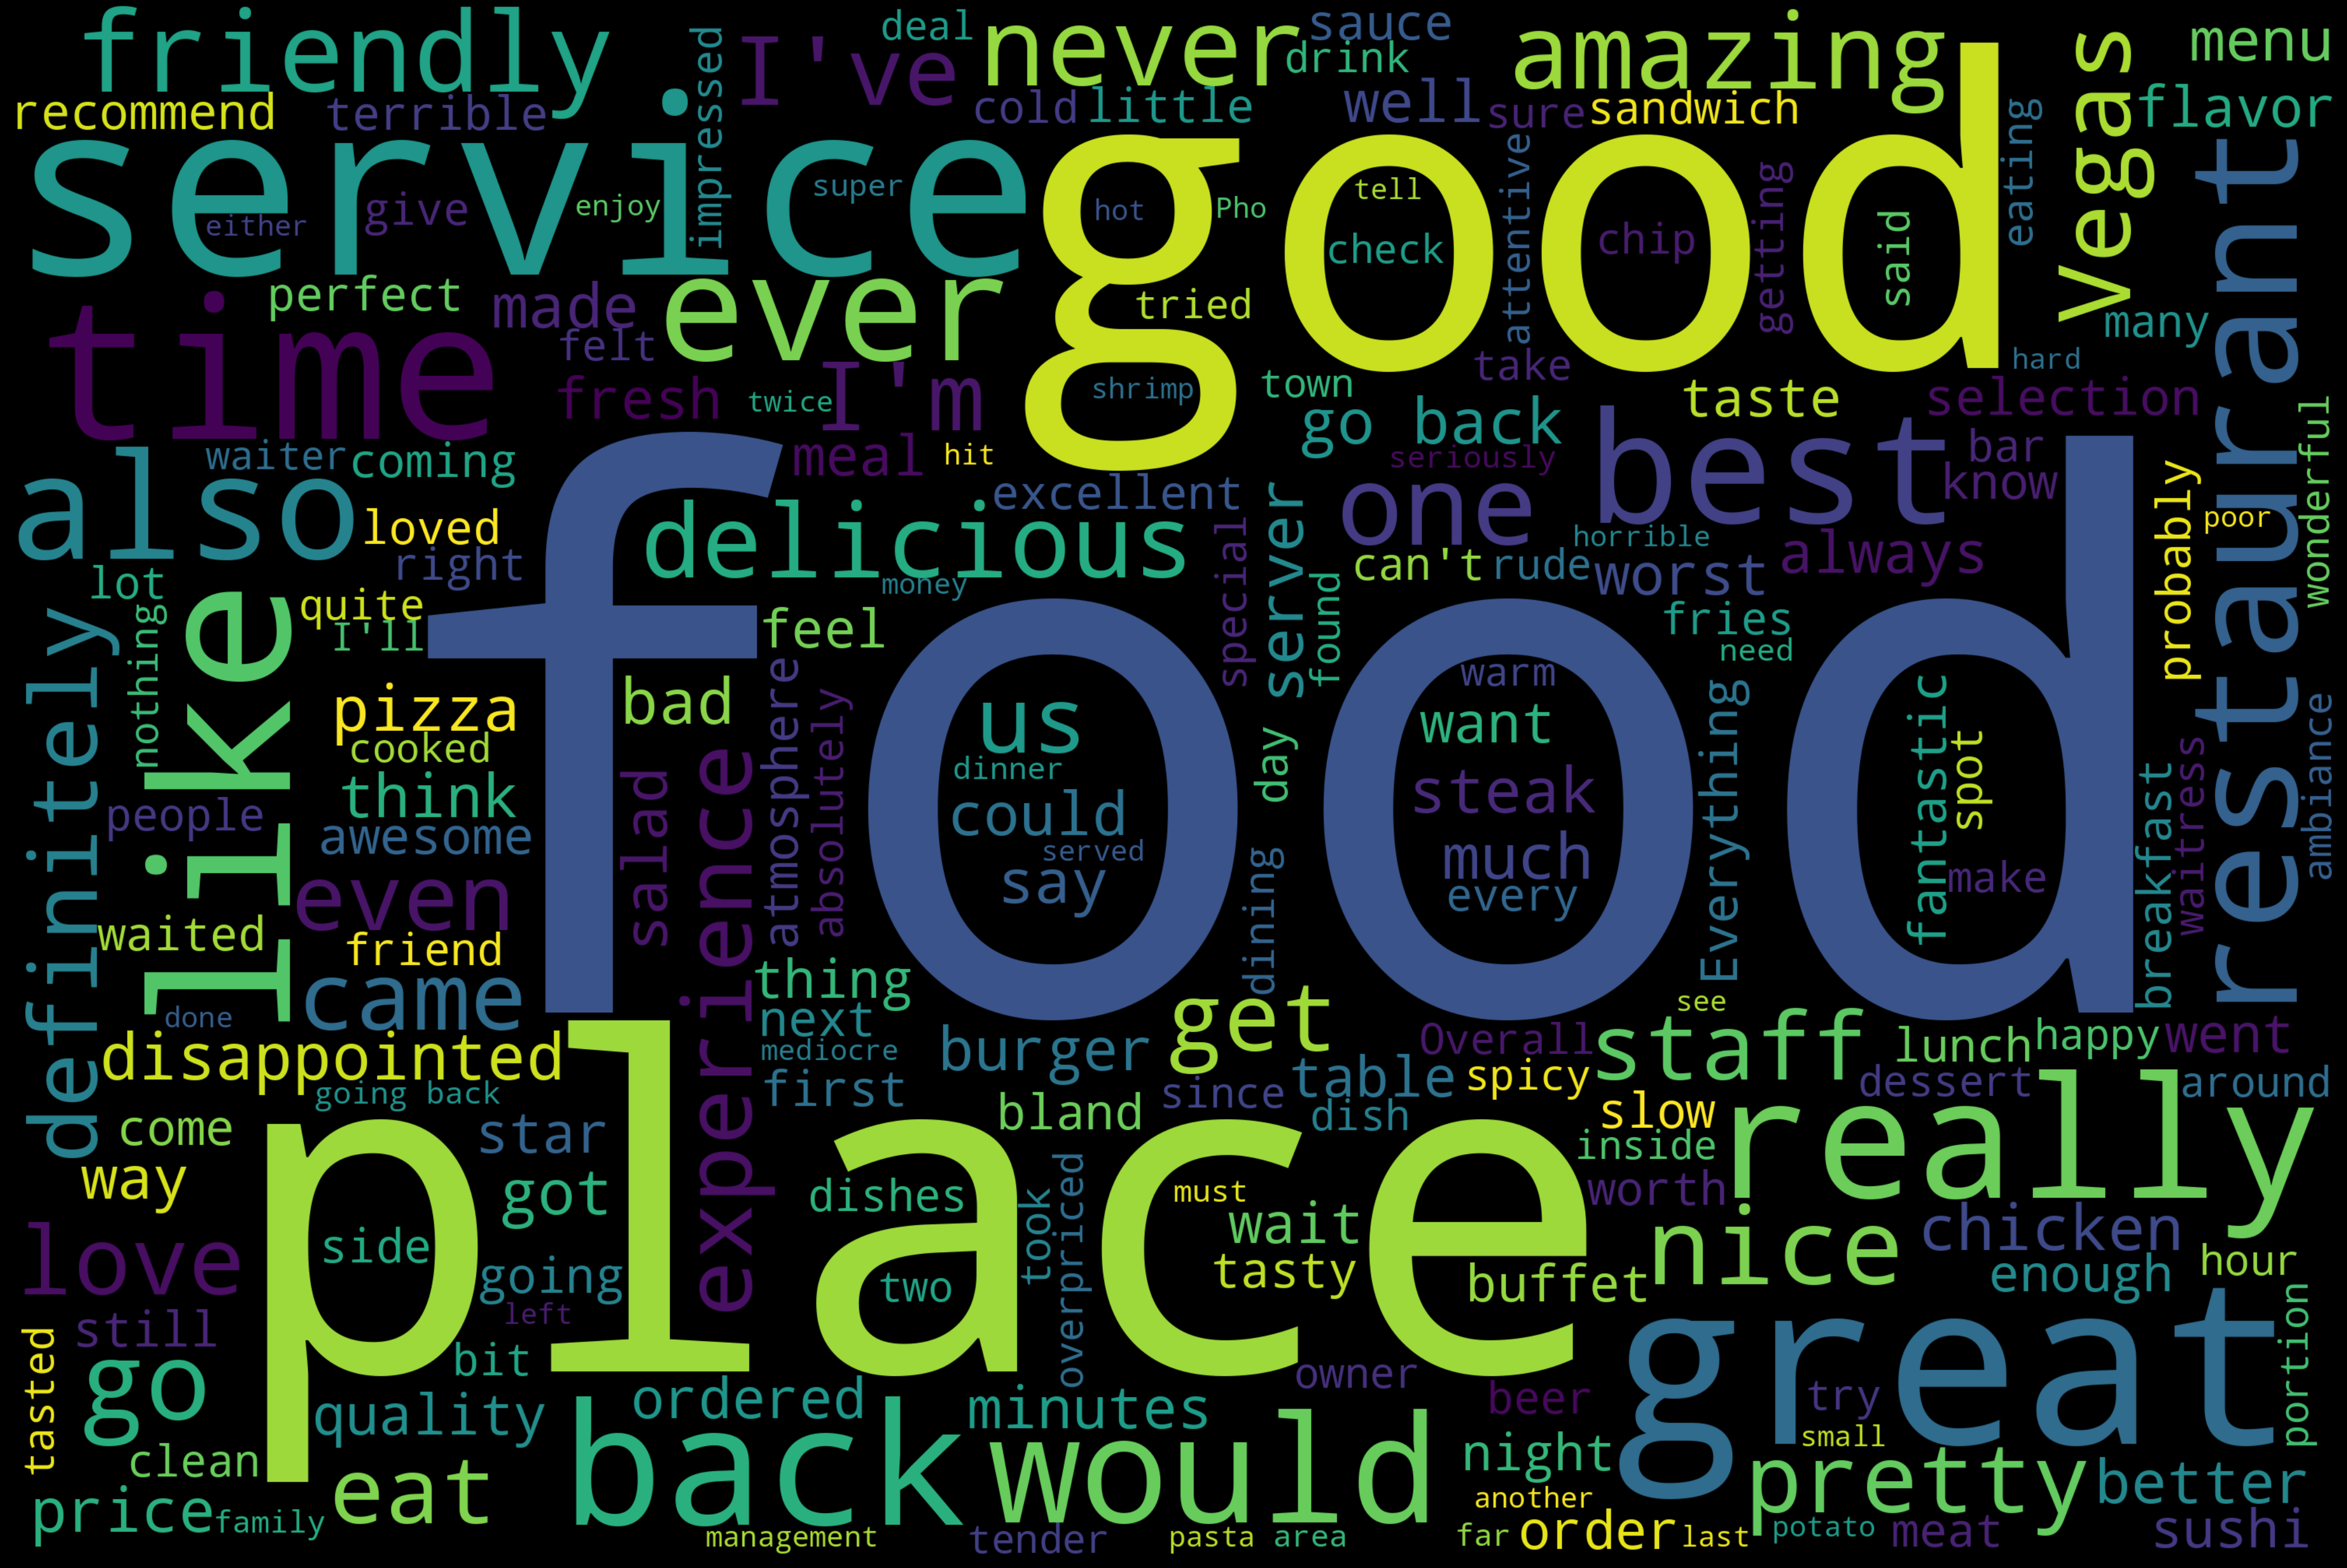

In [15]:
#WordCloud
# Coletar todas as palavras do dataset
text = ''
for review in yelp_df.Review.values:
    text += f" {review}"

#Construir a WordCloud
wordcloud = WordCloud(
    width = 3000,
    height = 2000,
    background_color = 'black',
    stopwords = set(nltk.corpus.stopwords.words("english"))).generate(text)

#Plotando
fig = plt.figure(
    figsize = (40, 30),
    facecolor = 'k',
    edgecolor = 'k')
plt.imshow(wordcloud, interpolation = 'bilinear') #Interpola melhor a visualização
plt.axis('off') #Retirando o eixo x e y
plt.tight_layout(pad=0)
plt.show()
del text

###**<font color=#FE8202> 3.4. Caracteres por avaliação**

In [16]:
# Quantidade de caracteres por avaliação
df_sentimentos_char = df_sentimentos.copy()
df_sentimentos_char['review_lenght'] = np.array(list(map(len, df_sentimentos_char.Review)))

In [17]:
median = df_sentimentos_char['review_lenght'].median()
mean = (df_sentimentos_char['review_lenght'].mean()).round(0).astype(int)
mode = df_sentimentos_char['review_lenght'].mode()[0]

print(f"Média de caracteres: {mean}")
print(f"Mediana de caracteres: {median}")
print(f"Moda de caracteres: {mode}")


Média de caracteres: 72
Mediana de caracteres: 55.0
Moda de caracteres: 35


Em média, as avaliações são escritas com 72 caracteres.

>**<font color=#FE8202> Quantidade de avaliações por faixa de caracter**

In [18]:
# Criando o dataframe agrupando pela quantidade caracteres
gr_review_tamanho = df_sentimentos_char[['review_lenght','Review']]
gr_review_tamanho =  (gr_review_tamanho.groupby(["review_lenght"]).count().reset_index())

In [19]:
# Criando as faixas por quantidade de caracteres
classes = [0, 30, 50, 100, 199, 301,400,500, 10000000]

labels = ['0-30', '31-50', '51 e 100', '101-200',
          '201-300','301-400','401-500','500 +']

classes = pd.cut(x=gr_review_tamanho.review_lenght, bins=classes, labels=labels)
gr_review_tamanho['Caracter_Agrupado'] = classes

# Agrupando por faixa e contando a quantidade de avaliações
gr_review_faixa=gr_review_tamanho.groupby(['Caracter_Agrupado'])['Review'].sum().reset_index()


In [20]:
fig0 = px.bar(gr_review_faixa, x="Caracter_Agrupado", y="Review",
             template="plotly_dark",
             text_auto=True,
             height=500, #altura
             width=1000,  #largura
             color_discrete_sequence=["#FE8202"],
             hover_data=['Caracter_Agrupado'],

             title = "Faixa de caracteres por avaliação")
fig0.update_traces(textposition='outside')
fig0.update_yaxes(showticklabels=True)
fig0.update_xaxes(showgrid=False)
fig0.update_yaxes(showgrid=True)
fig0.update_layout(xaxis = dict(linecolor='rgba(0,0,0,1)', # adicionando linha em y = 0
                                tickmode = 'array', # alterando o modo dos ticks
                                tickvals = gr_review_faixa['Caracter_Agrupado'], # setando a posição do tick de x
                                ticktext = gr_review_faixa['Caracter_Agrupado']),# setando o valor do tick de x
                                title_x = 0.5) #centralizando o titulo

fig0.show()

A maioria das avaliações estão escritas entre 51 a 100 caracteres.
>
Totalizando 1001 avaliações

#**<font color=#FE8202> 4. Pré-processamento**

###**<font color=#FE8202> 4.1. Divisão Treino e Teste**

In [21]:
# Divisão em treino e teste
# 80% para dados de treino e 20% para dados de teste
data_train = df_sentimentos.sample(2200, random_state=42)
data_test = df_sentimentos.loc[set(df_sentimentos.index.values) - set(data_train.index.values), :]

In [22]:
data_train.sort_index()

Review  sentiment
0     So there is no way for me to plug it in here i...          0
2                                Great for the jawbone.          1
3     Tied to charger for conversations lasting more...          0
5     I have to jiggle the plug to get it to line up...          0
6     If you have several dozen or several hundred c...          0
...                                                 ...        ...
2743  I think food should have flavor and texture an...          0
2744                           Appetite instantly gone.          0
2745  Overall I was not impressed and would not go b...          0
2746  The whole experience was underwhelming, and I ...          0
2747  Then, as if I hadn't wasted enough of my life ...          0

[2200 rows x 2 columns]

In [23]:
data_test.sort_index()

Review  sentiment
1                           Good case, Excellent value.          1
4                                     The mic is great.          1
11    He was very impressed when going from the orig...          1
16                  I advise EVERYONE DO NOT BE FOOLED!          0
19    It clicks into place in a way that makes you w...          0
...                                                 ...        ...
2724  too bad cause I know it's family owned, I real...          0
2726               I vomited in the bathroom mid lunch.          0
2727  I kept looking at the time and it had soon bec...          0
2730                            Food was below average.          0
2740  A lady at the table next to us found a live gr...          0

[548 rows x 2 columns]

###**<font color=#FE8202> 4.2. Limpeza de dados**

**Técnicas utilizadas:**
>
**Tokenização:** Quebrar o conjunto de texto em tokens individuais.
>
**Stop-words:** Remoção de palavras comuns que não contribuem com muita informação.
>
**Lematização:** Reduz a palavra ao seu lema, que é a forma no masculino e singular.

In [24]:
# Defininindo a função
# Remoção de pontuação, stopwords, palavras de domínio e depois aplicação de lematização
def text_preprocess(text, lang, domain_stopwords=[]):

    stop_words = nltk.corpus.stopwords.words(lang) # lang='portuguese' or lang='english'

    # Transforma em caixa baixa
    s = str(text).lower()

    # Remove pontuação
    table = str.maketrans({key: None for key in string.punctuation.replace("'", "")})
    s = s.translate(table)
    s = s.translate(str.maketrans({"'" : " "}))

    # Obtenção dos tokens
    tokens = word_tokenize(s)

    # Stop-words
    words = [word for word in tokens if not word in stop_words and not word.isdigit()] # remove stopwords e dígitos

    # Lemmatizar os tokens
    lemmatizer = WordNetLemmatizer()
    words = list(map(lemmatizer.lemmatize, words))
    domain_stopwords = list(map(lemmatizer.lemmatize, domain_stopwords))

    words = [word for word in words if not word in domain_stopwords] # remove palavras de domínio


    return " ".join(words).strip()

Agora iremos remover algumas palavras de domínio.
>
Para encontrá-las, vimos no passo 3.3 quais eram as palavras mais frequentes em cada uma das bases (amazon, imdb, yelp).
>
Com as mais frequentes, que julgamos que não influenciavam no sentimento da sentença, removemos elas das avaliações.

In [59]:
#amazon_domain_words = ['phone',  'product', 'sound', 'headset', 'battery']

#imdb_domain_words = ['movie', 'film', 'story', 'script', 'watching', 'character', 'actor', 'scene', 'person', 'people']

#yelp_domain_words = ['place', 'time', 'food', 'restaurant', 'vegas', 'eat', 'us', 'chicken', 'pizza', 'salad', 'menu', 'sushi', 'buffet', 'meal', 'burger', 'steak']

#domain_words = list(set(amazon_domain_words + imdb_domain_words + yelp_domain_words))

amazon_domain_words = ['movie', 'phone', 'film', 'food', 'place', 'time', 'service', 'product', 'sound', 'headset', 'battery']
imdb_domain_words = ['story', 'script', 'watching', 'character', 'actor', 'scene', 'person', 'people']
yelp_domain_words = ['food', 'restaurant', 'vegas', 'eat', 'us', 'chicken', 'pizza', 'salad', 'menu', 'sushi', 'buffet', 'meal', 'burger', 'steak']
domain_words = list(set(amazon_domain_words + imdb_domain_words + yelp_domain_words))


In [58]:
# Realizando a limpeza
data_train['Review'] = data_train['Review'].apply(text_preprocess, args=('english', domain_words))
data_test['Review'] = data_test['Review'].apply(text_preprocess, args=('english', domain_words))

#**<font color=#FE8202> 5. Word Embeddings**

Word embeddings é uma técnica em que palavras são transformadas em uma representação na forma de um vetor numérico.
>
Esses vetores tentam capturar várias características de uma palavra em relação ao texto geral.
>
A motivação para representar palavras na forma de vetores em PLN é que algoritmos de aprendizado de máquina não são capazes de processar informação de texto bruto, apenas a sua representação numérica.

###**<font color=#FE8202> 5.1. Bag of Words (BOW)**

Bag of Words, é uma das maneiras mais populares de realizar transformações do texto.
>
Não é considerado uma Word Embeddings, mas reconhecemos a sua importância, e usaremos para transformar e posteriormente, aplicar algoritmos de Machine Learning.
>
Sendo assim, precisamos representar numericamente os dados,ou seja, codificar os dados em números que podem ser usados por algoritmos.
>
Para isso,podemos criar uma bag of words(BOW).
>
Ela é uma das técnicas de vetorização de texto mais simples.
>
A intuição por trás da BOW é que duas sentenças são ditas semelhantes se contiverem um conjunto de palavras semelhante.

In [60]:
# Obtendo a bag-of-words
def compute_bag_of_words(dataset, lang, domain_stopwords=[]):
    vectorizer = TfidfVectorizer(max_features=1000)
    X = vectorizer.fit_transform(dataset['Review'])

    #count_vect_df = pd.DataFrame(X.todense(), columns=vectorizer.get_feature_names())
    count_vect_df = pd.DataFrame(X.todense(), columns=vectorizer.vocabulary_.keys())

    return count_vect_df, vectorizer

In [61]:
bow_train_df, vectorizer = compute_bag_of_words(data_train,'english')
bow_test_df = pd.DataFrame(vectorizer.transform(data_test['Review']).todense(), columns=vectorizer.vocabulary_.keys())

In [62]:
bow_train_df.head()

close  house  price      good  stay  must  get  breakfast  least  let  ...  \
0    0.0    0.0    0.0  0.000000   0.0   0.0  0.0        0.0    0.0  0.0  ...   
1    0.0    0.0    0.0  0.000000   0.0   0.0  0.0        0.0    0.0  0.0  ...   
2    0.0    0.0    0.0  0.349128   0.0   0.0  0.0        0.0    0.0  0.0  ...   
3    0.0    0.0    0.0  0.000000   0.0   0.0  0.0        0.0    0.0  0.0  ...   
4    0.0    0.0    0.0  0.000000   0.0   0.0  0.0        0.0    0.0  0.0  ...   

   shipping  duck  rock  damn  stink  puppet  shakespear  plain  nut  \
0       0.0   0.0   0.0   0.0    0.0     0.0         0.0    0.0  0.0   
1       0.0   0.0   0.0   0.0    0.0     0.0         0.0    0.0  0.0   
2       0.0   0.0   0.0   0.0    0.0     0.0         0.0    0.0  0.0   
3       0.0   0.0   0.0   0.0    0.0     0.0         0.0    0.0  0.0   
4       0.0   0.0   0.0   0.0    0.0     0.0         0.0    0.0  0.0   

   watchable  
0        0.0  
1        0.0  
2        0.0  
3        0.0  
4        0.0  

[5 rows x 1000 columns]

In [63]:
bow_test_df.head()

close  house  price  good  stay  must  get  breakfast  least  let  ...  \
0    0.0    0.0    0.0   0.0   0.0   0.0  0.0        0.0    0.0  0.0  ...   
1    0.0    0.0    0.0   0.0   0.0   0.0  0.0        0.0    0.0  0.0  ...   
2    0.0    0.0    0.0   0.0   0.0   0.0  0.0        0.0    0.0  0.0  ...   
3    0.0    0.0    0.0   0.0   0.0   0.0  0.0        0.0    0.0  0.0  ...   
4    0.0    0.0    0.0   0.0   0.0   0.0  0.0        0.0    0.0  0.0  ...   

   shipping  duck  rock  damn  stink  puppet  shakespear  plain  nut  \
0       0.0   0.0   0.0   0.0    0.0     0.0         0.0    0.0  0.0   
1       0.0   0.0   0.0   0.0    0.0     0.0         0.0    0.0  0.0   
2       0.0   0.0   0.0   0.0    0.0     0.0         0.0    0.0  0.0   
3       0.0   0.0   0.0   0.0    0.0     0.0         0.0    0.0  0.0   
4       0.0   0.0   0.0   0.0    0.0     0.0         0.0    0.0  0.0   

   watchable  
0        0.0  
1        0.0  
2        0.0  
3        0.0  
4        0.0  

[5 rows x 1000 columns]

In [64]:
top_palavras = np.sum(bow_train_df, axis=0).sort_values(ascending=False)
top_palavras[:10]

created       69.587684
new           67.996704
gross         35.735648
received      33.569949
part          32.697978
dish          27.981331
sturdy        27.721166
still         25.982876
going         25.830218
impressive    24.077439
dtype: float64

###**<font color=#FE8202> 5.2. Word2Vec**

A eficácia do Word2Vec vem de sua capacidade de
agrupar vetores de palavras semelhantese realizar cálculos sobre eles
que têm uma relação de semântica entre as palavras.
>
Dado um conjunto de dados grande o suficiente, o Word2Vec pode fazer estimativas sobre o significado de uma palavra com base em suas ocorrências no texto. Essas estimativas geram associações de palavras com outras palavras do
corpus.

In [65]:
doc_embeddings_train = []
for index, row in data_train.iterrows():
  sentence = row['Review'].split()
  L = []
  for token in sentence:
    try:
      L.append(word2vec_model[token])
    except:
      1
  if len(L) > 0: opinion_vec = np.mean(np.array(L),axis=0)
  else: opinion_vec = np.zeros(300)
  doc_embeddings_train.append(opinion_vec)

w2v_train_df = pd.DataFrame(np.array(doc_embeddings_train))

doc_embeddings_test = []
for index, row in data_test.iterrows():
  sentence = row['Review'].split()
  L = []
  for token in sentence:
    try:
      L.append(word2vec_model[token])
    except:
      1
  if len(L) > 0: opinion_vec = np.mean(np.array(L),axis=0)
  else: opinion_vec = np.zeros(300)
  doc_embeddings_test.append(opinion_vec)

w2v_test_df = pd.DataFrame(np.array(doc_embeddings_test))

In [66]:
w2v_train_df.head()

0         1         2         3         4         5         6    \
0  0.044164 -0.028524 -0.068624  0.098246  0.021952 -0.010264  0.107727   
1 -0.034436 -0.066211 -0.069434  0.211426 -0.036560 -0.021201  0.088428   
2  0.083897  0.089914  0.082676  0.034842 -0.047459  0.005266  0.078003   
3 -0.013878  0.007651  0.006733  0.103584 -0.068181  0.069942  0.105398   
4  0.013090  0.060126  0.132475  0.053630 -0.050835  0.051792  0.078071   

        7         8         9    ...       290       291       292       293  \
0  0.002035  0.167969  0.105896  ... -0.081940  0.082642 -0.214193  0.077148   
1  0.026465  0.091992 -0.007812  ... -0.058154  0.082373 -0.081104  0.110226   
2 -0.157506  0.090681  0.032104  ... -0.081297  0.128645 -0.114027  0.041513   
3 -0.076410  0.100379  0.119794  ... -0.077036  0.117394 -0.143893  0.039251   
4 -0.097690  0.065488  0.152913  ... -0.004433  0.036296 -0.094303  0.080675   

        294       295       296       297       298       299  
0  0.012004  0.086812  0.047058 -0.005168  0.022569 -0.021291  
1  0.001990  0.007959 -0.117700 -0.005688  0.082764  0.005933  
2 -0.009181  0.011121 -0.023019  0.003985  0.086716  0.050223  
3 -0.047028  0.036105  0.003657 -0.067345 -0.005429 -0.034203  
4 -0.061571  0.066644 -0.025052 -0.108575  0.030426 -0.041260  

[5 rows x 300 columns]

###**<font color=#FE8202> 5.3. BERT**

**BERT - Bidirectional Encoder Representations from Transformers**
>
O BERT, ao contrário do word2vec, não gera word embeddings únicos para
cada palavra ao final de seu treinamento. O que ele faz é fornecer um modelo
que, dada uma frase inteira, irá gerar um word embedding para cada palavra dentro
do contexto da frase.

In [67]:
#Setup
bert_model = SentenceTransformer('distiluse-base-multilingual-cased')

In [68]:
bert_train_df = data_train['Review'].apply(bert_model.encode)
bert_test_df = data_test['Review'].apply(bert_model.encode)

bert_train_df = pd.DataFrame(np.array(list(map(np.array, bert_train_df))))
bert_test_df = pd.DataFrame(np.array(list(map(np.array, bert_test_df))))

In [69]:
bert_train_df.head()

0         1         2         3         4         5         6    \
0 -0.051301  0.010129  0.021332 -0.039849  0.070835 -0.036481  0.019380   
1  0.005089 -0.062995 -0.047464 -0.002213  0.018450  0.029112 -0.044882   
2  0.003021  0.019980 -0.059656 -0.023391  0.095549 -0.021603  0.075058   
3  0.015316  0.011052  0.060555 -0.061605  0.073337 -0.068167  0.052081   
4 -0.057670 -0.068754  0.018881 -0.029647  0.070910 -0.055336 -0.013337   

        7         8         9    ...       502       503       504       505  \
0  0.008176 -0.026579  0.075519  ...  0.027423 -0.031540  0.006369  0.022255   
1  0.070830  0.044709  0.009254  ... -0.005599 -0.073230  0.001028 -0.001490   
2  0.065431 -0.006348 -0.021283  ...  0.016712 -0.019533  0.020284 -0.089986   
3  0.014611  0.033850  0.035802  ... -0.011877  0.024502  0.029773  0.022519   
4  0.020015 -0.062383  0.044318  ...  0.018318  0.001289  0.013645  0.017686   

        506       507       508       509       510       511  
0 -0.027824 -0.009504  0.011829 -0.074677 -0.029289  0.046449  
1  0.000251 -0.001904 -0.090002 -0.025886  0.024428 -0.006843  
2 -0.009596 -0.045469  0.015813 -0.045987  0.066562  0.024316  
3 -0.011681  0.064539 -0.012013 -0.052331 -0.026170  0.014781  
4 -0.067523 -0.081658  0.006563 -0.031492  0.090490 -0.011106  

[5 rows x 512 columns]

#**<font color=#FE8202> 6. Modelo de Machine Learning**

Agora que temos 3 Embeddings, vamos avaliar a acurácia de cada uma delas em modelos de Machine Learning.

Algoritimos: **Regressão Logística, SVM, MLP, Floresta aleatória e KNN**

###**<font color=#FE8202> 6.1 Criação e avaliação de modelos**

In [70]:
def test_model(model, X_train, y_train, X_test, y_test, score_func=accuracy_score):
    model.fit(X_train, y_train)
    train_score = score_func(y_train, model.predict(X_train))
    test_score = score_func(y_test, model.predict(X_test))
    return train_score, test_score

def print_scores(train_score, test_score, score_name='Acuracia'):
    score_name = score_name.lower()
    print(f'\tTreino: {score_name} = {train_score:.4f}')
    print(f'\tTeste:  {score_name} = {test_score:.4f}')

In [71]:
#Iniciando
svm = SVC()
mlp = MLPClassifier(max_iter=300)
# Usando hiperparâmetro de regularização C
log_reg = LogisticRegression(C=0.42)
random_forest = RandomForestClassifier(max_depth=5)
knn = KNeighborsClassifier()

models = [(log_reg, 'Logistic Regression'),
          (svm, 'Support Vector Machine'),
          (mlp, 'Multilayer Perceptron'),
          (random_forest, 'Random Forest'),
          (knn, 'KNN')]

embeddings = [(bow_train_df, bow_test_df, 'Bag of words'),
              (w2v_train_df, w2v_test_df, 'Word2Vec'),
              (bert_train_df, bert_test_df, 'BERT')]

y_train = data_train.iloc[:, -1]
y_test = data_test.iloc[:, -1]

all_scores = []

for model in models:
    for embedding in embeddings:
        model_scores = test_model(model[0], embedding[0], y_train, embedding[1], y_test)
        print(f'Avaliacao para: {embedding[2]} usando {model[1]}')
        print_scores(*model_scores)
        all_scores.append((model[1], embedding[2], *model_scores))
        print()

Avaliacao para: Bag of words usando Logistic Regression
	Treino: acuracia = 0.8723
	Teste:  acuracia = 0.7555

Avaliacao para: Word2Vec usando Logistic Regression
	Treino: acuracia = 0.8486
	Teste:  acuracia = 0.8066

Avaliacao para: BERT usando Logistic Regression
	Treino: acuracia = 0.8468
	Teste:  acuracia = 0.8084

Avaliacao para: Bag of words usando Support Vector Machine
	Treino: acuracia = 0.9582
	Teste:  acuracia = 0.7609

Avaliacao para: Word2Vec usando Support Vector Machine
	Treino: acuracia = 0.9105
	Teste:  acuracia = 0.8193

Avaliacao para: BERT usando Support Vector Machine
	Treino: acuracia = 0.9386
	Teste:  acuracia = 0.8102

Avaliacao para: Bag of words usando Multilayer Perceptron
	Treino: acuracia = 0.9773
	Teste:  acuracia = 0.7372

Avaliacao para: Word2Vec usando Multilayer Perceptron
	Treino: acuracia = 0.9918
	Teste:  acuracia = 0.7993

Avaliacao para: BERT usando Multilayer Perceptron
	Treino: acuracia = 0.9936
	Teste:  acuracia = 0.7883

Avaliacao para: Bag of

In [72]:
#Criando um dataframe com todas as avaliações
scores_df = pd.DataFrame(all_scores, columns=['Model', 'Embedding', 'Train acc', 'Test acc'])
scores_df['Test_acc'] = scores_df['Test acc'].round(2) #com 2 casas decimais
scores_df.head()

Model     Embedding  Train acc  Test acc  Test_acc
0     Logistic Regression  Bag of words   0.872273  0.755474      0.76
1     Logistic Regression      Word2Vec   0.848636  0.806569      0.81
2     Logistic Regression          BERT   0.846818  0.808394      0.81
3  Support Vector Machine  Bag of words   0.958182  0.760949      0.76
4  Support Vector Machine      Word2Vec   0.910455  0.819343      0.82

In [73]:
#Plotando grafico de barras com as avaliações
fig = px.bar(scores_df, x="Model", y="Test_acc", color='Embedding', barmode="group",
             template="plotly_dark",
             text_auto=True,
             title = "Acurácia de Embedding por Modelo",
             labels=dict(Model="Modelo", Test_acc = "Acurácia"),

             color_discrete_map={
              'Bag of words': '#8e38d3','Word2Vec': '#85d338', 'BERT':'#1d1160'
              }
             )
fig.show()

O melhor desempenho foi do Embedding Word2Vec com o modelo de Support Vector Machine.

###**<font color=#FE8202> 5.2 Otimização de hiperparâmetros**

In [74]:
#Create a dictionary and fill out some parameters for kernels, C and gamma
grid_parameters = {'C': [0.1,1, 10, 100],
                   'gamma': [1,0.1,0.01,0.001],
                   'kernel': ['poly','rbf', 'sigmoid','linear']}

grid = GridSearchCV(SVC(),grid_parameters,refit=True, cv=10, verbose=3)

grid_result = grid.fit(w2v_train_df, y_train)


Fitting 10 folds for each of 64 candidates, totalling 640 fits
[CV 1/10] END ......C=0.1, gamma=1, kernel=poly;, score=0.845 total time=   0.4s
[CV 2/10] END ......C=0.1, gamma=1, kernel=poly;, score=0.841 total time=   0.4s
[CV 3/10] END ......C=0.1, gamma=1, kernel=poly;, score=0.809 total time=   0.4s
[CV 4/10] END ......C=0.1, gamma=1, kernel=poly;, score=0.850 total time=   0.4s
[CV 5/10] END ......C=0.1, gamma=1, kernel=poly;, score=0.850 total time=   0.4s
[CV 6/10] END ......C=0.1, gamma=1, kernel=poly;, score=0.855 total time=   0.5s
[CV 7/10] END ......C=0.1, gamma=1, kernel=poly;, score=0.827 total time=   0.6s
[CV 8/10] END ......C=0.1, gamma=1, kernel=poly;, score=0.800 total time=   0.6s
[CV 9/10] END ......C=0.1, gamma=1, kernel=poly;, score=0.827 total time=   0.6s
[CV 10/10] END .....C=0.1, gamma=1, kernel=poly;, score=0.823 total time=   0.6s
[CV 1/10] END .......C=0.1, gamma=1, kernel=rbf;, score=0.695 total time=   1.0s
[CV 2/10] END .......C=0.1, gamma=1, kernel=rb

In [75]:
#Avaliando os resultados
print(grid.best_score_)
print(grid.best_params_)
print(grid.best_estimator_)

0.8327272727272728
{'C': 0.1, 'gamma': 1, 'kernel': 'poly'}
SVC(C=0.1, gamma=1, kernel='poly')


Já temos a melhor configuração, e no próximo passo, iremos configurar o modelo com esses parâmetros.

###**<font color=#FE8202> 5.3 Melhor modelo**

In [91]:
# Preparação do modelo
inicio = time.time()
best_modelo = SVC(C=0.1, gamma=1, kernel='poly')
best_modelo.fit(w2v_train_df, y_train)
fim = time.time()
log_svm = fim-inicio

In [92]:
# Estimativa da acurácia no conjunto de teste
previsoes_svm = best_modelo.predict(w2v_test_df)

# Avaliação

#Acurácia
print("Acurácia: %.2f%%" % (accuracy_score(y_test, previsoes_svm) * 100.0))
# Precisão
print("Precisão: %.2f%%" % (precision_score(y_test, previsoes_svm) * 100.0))
# Recall / Revocação
print("Revocação: %.2f%%" % (recall_score(y_test, previsoes_svm) * 100.0))
# F1 score
print("F1-Score: %.2f%%" % (f1_score(y_test, previsoes_svm) * 100.0))
print(f"Tempo de treinamento: {log_svm:.2f}s")

Acurácia: 83.03%
Precisão: 85.82%
Revocação: 80.70%
F1-Score: 83.18%
Tempo de treinamento: 0.69s


Com os ajustes dos hiperparâmetros, conseguimos alcançar uma acurácia de 83,03%, contra 82% do modelo sem a configuração ideal.